# Transform each voxels time course into z-scores


This notebook takes the raw fMRI time course of each fMRI session, and pre-processes it. We apply:

* z-scoring (mean zero, std one)
* detrending (removing linear drifts)
* smoothing with 6mm FWHM
* regressing out movement-associated signal changes

### import modules

In [2]:
import os
import numpy as np
import pandas as pd

from nilearn import input_data, plotting, image

import matplotlib.pyplot as plt
import seaborn as sns

In [3]:
sns.set_context('poster')
sns.set_style('ticks')

### get directory

In [ ]:
# after converstion to .py, we can use __file__ to get the module folder
try:
    thisDir = os.path.realpath(__file__)
# in notebook form, we take the current working directory (we need to be in 'notebooks/' for this!)
except:
    thisDir = '.'
# convert relative path into absolute path, so this will work with notebooks and py modules
supDir = os.path.abspath(os.path.join(os.path.dirname(thisDir), '..'))

supDir

### get data

In [ ]:
data_df = pd.read_csv('../data/interim/csv/info_epi_df.csv',index_col=[0])
data_df.tail()

### show a file

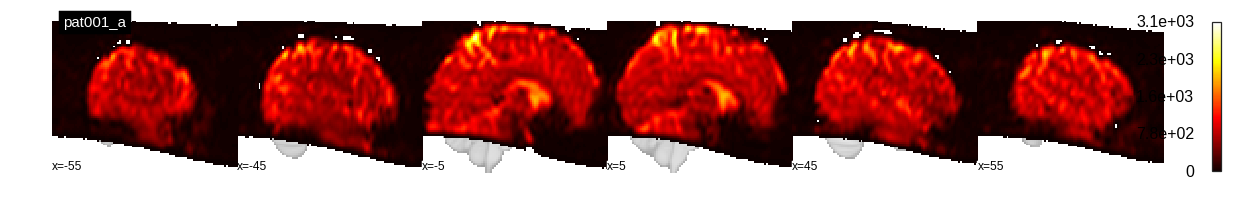

In [8]:
for entry in data_df.index:
    this_epi = data_df.loc[entry]['epi']
    plotting.plot_stat_map(image.mean_img(this_epi),display_mode='x',title=entry,cut_coords=(-55,-45,-5,5,45,55))
    plt.show()
    break

### show example of movement parameters

/usr/local/venv/lib/python2.7/site-packages/ipykernel/__main__.py:4: ParserWarning: Falling back to the 'python' engine because the 'c' engine does not support regex separators (separators > 1 char and different from '\s+' are interpreted as regex); you can avoid this warning by specifying engine='python'.


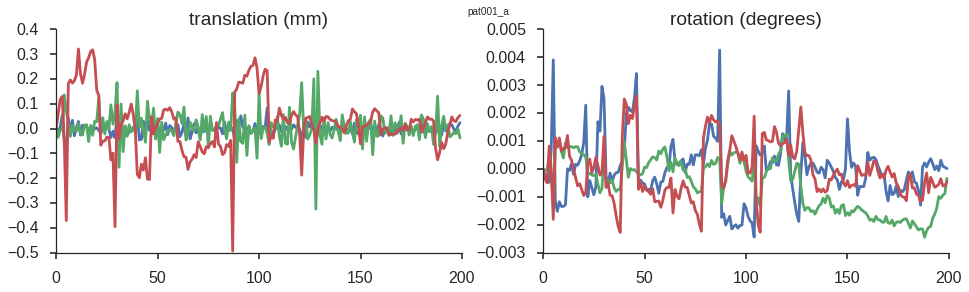

In [9]:
fig,(ax1,ax2) = plt.subplots(1,2,figsize=(16,4))
for entry in data_df.index:
    this_move = data_df.loc[entry]['rp']
    this_move_df = pd.read_csv(this_move,sep='  ',header=None,index_col=None)

    ax1.plot(this_move_df[this_move_df.columns[:3]])
    ax1.set_title('translation (mm)')
    ax2.plot(this_move_df[this_move_df.columns[3:]])
    ax2.set_title('rotation (degrees)')
    sns.despine()
    plt.suptitle(entry)
    plt.show()
    
    break

## clean and z-score the timecourse of each voxel

### initalizing whole-brain masker objects

In [10]:
masker = input_data.NiftiMasker(
    mask_img='%s/data/external/MNI152_T1_2mm_brain_mask.nii.gz'%supDir,
    smoothing_fwhm=6,
    detrend=True,
    standardize=True).fit()

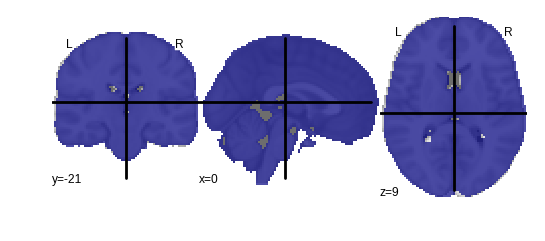

In [11]:
plotting.plot_roi( masker.mask_img_ );

### extract data for one participant

select the participant

In [12]:
this_df = data_df.iloc[-1]

In [ ]:
this_df

extract the data into an array

In [14]:
fmri_data = masker.transform(this_df.epi,confounds=[this_df.rp])

/usr/local/venv/lib/python2.7/site-packages/scipy/ndimage/interpolation.py:435: UserWarning: The behaviour of affine_transform with a one-dimensional array supplied for the matrix parameter will change in scipy 0.18.0.
  "The behaviour of affine_transform with a one-dimensional "


In [15]:
fmri_data.shape

(200, 228483)

### save images for one participant

In [32]:
def make_p(p_name,data_df,masker=masker):
    """clean and z-score one 4D image"""
    
    this_df = data_df.loc[p_name]
    
    fmri_data = masker.transform(this_df.epi,confounds=[this_df.rp])    
    im = masker.inverse_transform( fmri_data )

    out_name = '../data/interim/nii/z_imOrig_%s.nii.gz'%p_name
    im.to_filename(out_name)
    data_df.loc[p_name,'z-scored'] = out_name
    
    # return the updated table, which now contains an entry indicating
    # the filename of the tranformed data
    return data_df

### function for toolbox use

Exported as a .py file using our helper functions, this notebooks transforms based on the cell tags. In this case, the make_p function above, which takes information from the group table and updates the table information is swapped for the make_p function below, which uses filenames as input/output.

In [11]:
#def make_p(pFolder, pName, masker=masker):
#
#    fmri_filename = os.path.join(pFolder, ''.join(['wr', pName, '.nii.gz']))
#    confound_filename = os.path.join(pFolder, ''.join(['rp_', pName, '.txt']))
#
#    fmri_data = masker.transform(fmri_filename, confounds=[confound_filename])
#    im = masker.inverse_transform(fmri_data)
#
#    out_name = os.path.join(pFolder, ''.join(['z_imOrig_', pName, '.nii.gz']))
#    im.to_filename(out_name)
#
#    return out_name

#### Example:

In [17]:
p_name = data_df.index[-1]
p_name

'pat101_a'

The output is an updated data frame:

In [18]:
data_df = make_p(p_name,data_df)

In [ ]:
data_df.tail()

Show the average image, before and after

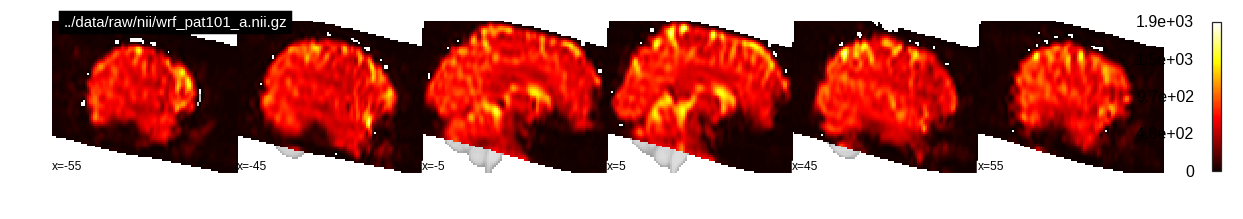

/usr/local/venv/lib/python2.7/site-packages/nilearn/plotting/displays.py:649: UserWarning: empty mask
  get_mask_bounds(new_img_like(img, not_mask, affine))


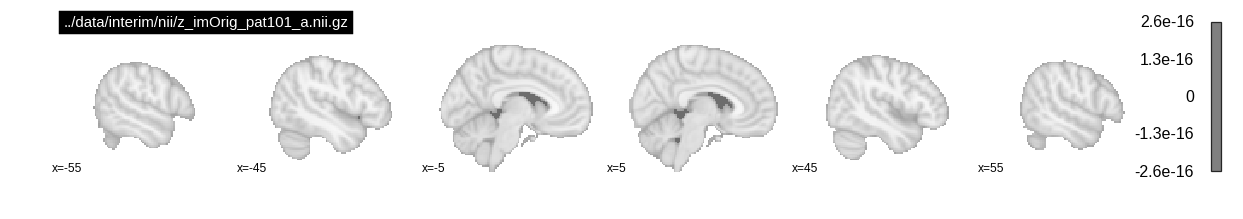

In [20]:
raw_im = data_df.loc[p_name]['epi']
plotting.plot_stat_map(image.mean_img(raw_im),display_mode='x',title=raw_im,cut_coords=(-55,-45,-5,5,45,55))
plt.show()
    
z_im = data_df.loc[p_name]['z-scored']
plotting.plot_stat_map(image.mean_img(z_im),display_mode='x',title=z_im,cut_coords=(-55,-45,-5,5,45,55))
plt.show()

On average, the value of each voxel should be zero now. That's why the mean image should be empty. But each individual volume will show us the deviation from the grand mean of zero, as we can see when picking out single volumes at random:

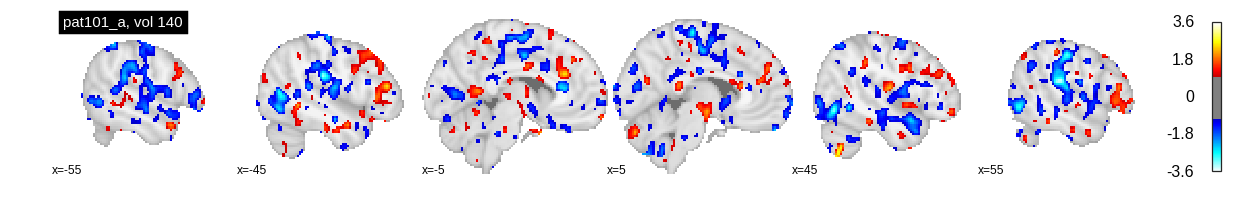

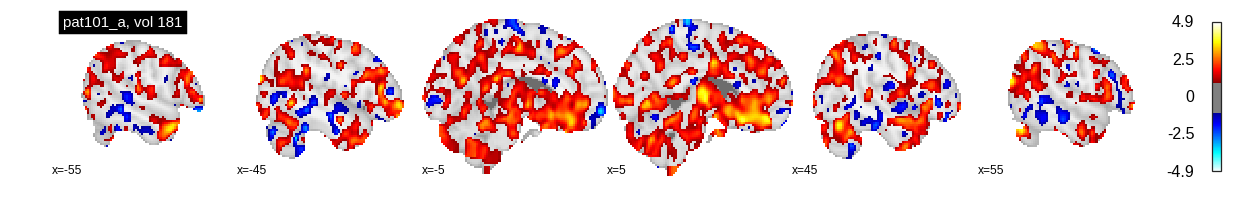

In [21]:
vol_num = np.random.randint(0,200)
plotting.plot_stat_map(image.index_img(z_im,vol_num),
                       display_mode='x',
                       threshold=1,
                       cut_coords=(-55,-45,-5,5,45,55),
                       title='%s, vol %s'%(p_name,vol_num));
vol_num = np.random.randint(0,200)
plotting.plot_stat_map(image.index_img(z_im,180),
                       display_mode='x',
                       threshold=1,
                       cut_coords=(-55,-45,-5,5,45,55),
                       title='%s, vol %s'%(p_name,vol_num));

### save images for all participants

In [34]:
for p_name in data_df.index:
    data_df = make_p(p_name,data_df)

### store updated dataframe

In [ ]:
data_df.tail()

In [36]:
data_df.shape, data_df.dropna().shape

((143, 5), (143, 5))

In [37]:
data_df.to_csv('../data/interim/csv/info_epi_zscored_df.csv')

### summary  

We now have a new 4D file for each observation, where each voxel's time course is cleaned of major confounds and z-scored to have zero mean and unit variance. These files can be accessed using the "z-scored" column in our updated table.


**************

< [Previous](01-mw-collect-data.ipynb) | [Contents](00-mw-overview-notebook.ipynb) | [Next >](03-mw-make-difference-ims.ipynb)